In [1]:
# Importazione librerie per grafica e per solver PLI
%matplotlib inline
import matplotlib.pyplot as pyplot
from gurobipy import *
import numpy
import time
import math

In [2]:
def DisegnaPunto(A):
    """
    Disegna un punto nel piano
    """
    pyplot.plot([A[0]], [A[1]], 'bo')

In [3]:
def DisegnaSegmento(A, B):
    """ 
    Disegna un segmento nel piano dal punto A a al punto B
    Vedi manuale a: http://matplotlib.org/api/pyplot_api.html
    """
    # Disegna il segmento
    pyplot.plot([A[0], B[0]], [A[1], B[1]], 'b')
    # Disegna gli estremi del segmento
    DisegnaPunto(A)
    DisegnaPunto(B)

In [4]:
# Lettura dati da file
def ParseFile(filename):
    doc = open(filename, 'r')
    # Salta le prime 3 righe
    for _ in range(3):
        doc.readline()
    # Leggi la dimensione
    n = int(doc.readline().split(' ')[2])
    # sala riga
    doc.readline()
    # Leggi la capacita
    C = int(doc.readline().split(' ')[2])
    # sala riga
    doc.readline()
    # Leggi posizioni
    Ps = {}
    for row in doc:
        row = row.rstrip().split(' ')
        if row[0] == 'DEMAND_SECTION':
            break
        row = map(lambda z: int(z), row)
        Ps[row[0]] = (row[1], row[2])
    # Leggi posizioni
    Ds = {}
    for row in doc:
        row = row.rstrip().split(' ')
        if row[0] == 'DEPOT_SECTION':
            break
        row = map(lambda z: int(z), row)
        Ds[row[0]] = row[1]
    d = int(doc.next().rstrip())

    return n, C, Ps, Ds, d

In [5]:
# Rappresentazione grafica di un'istanza
def PlotInstance(Ds, Ps, d):
    # Map data for scatter plot
    X = map(lambda z: z[1][0], Ps.items())
    Y = map(lambda z: z[1][1], Ps.items())
    Z = map(lambda z: 2*z[0], Ds.items())
    C = map(lambda z: 'b', Ds.items())
    # Depot
    Z[d-1] = 50
    C[d-1] = 'r'

    pyplot.scatter(X, Y, Z, C)

In [6]:
(n, C, Ps, Ds, d) = ParseFile("E-n30-k4.vrp")
#(n, C, Ps, Ds, d) = ParseFile("E-n51-k5.vrp")


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


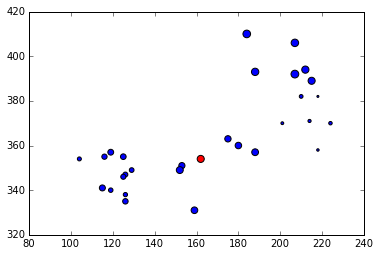

In [7]:
PlotInstance(Ds, Ps, d)

In [8]:
def Distance(A, B):
    return math.sqrt((A[0]-B[0])**2 + (A[1] - B[1])**2)

In [9]:
def VRP(n, K, C, Ps, Ds, d, F, TimeLimit):
    m = Model()
    m.setParam(GRB.Param.TimeLimit, TimeLimit)
    # Create variables
    x = {}
    for i in Ps:
        for j in Ps:
            if i != j :
                x[i,j] = m.addVar(obj=F(Ps[i], Ps[j]), vtype=GRB.BINARY,
                                  name='x'+str(i)+'_'+str(j))
    # Create Miller variables (subtour elimination)
    u = {}
    for i in Ds:
        if i != d:
            u[i] = m.addVar(obj=0.0, vtype=GRB.CONTINUOUS,
                            lb=Ds[i], ub=C, name='u'+str(i))
            
    m.update()
    # Add outdegree constraint
    for j in Ps:
        if j != d:
            Ls = filter(lambda z: z!=j, Ps)
            m.addConstr(quicksum(x[i,j] for i in Ls) == 1)
    # Add indegree constraint
    for i in Ps:
        if i != d:
            Ls = filter(lambda z: z!=i, Ps)
            m.addConstr(quicksum(x[i,j] for j in Ls) == 1)
    # Number of vehicles
    Ls = filter(lambda z: z!=d, Ps)                    
    m.addConstr(quicksum(x[i,d] for i in Ls) == K)
    m.addConstr(quicksum(x[d,j] for j in Ls) == K)
    # Subtour elimination constraints
    for i in Ls:
        for j in Ls:
            if i != j:
                m.addConstr( u[i] - u[j] +C*x[i,j] <= C - Ds[j] )

    m.update()

    # Solve the model
    m.optimize()
    solution = m.getAttr('x', x)
    selected = [(i,j) for (i,j) in solution if solution[i,j] > 0.5]

    for i,j in selected:
        DisegnaSegmento(Ps[i], Ps[j])
    print('')
    print('Optimal cost: %g' % m.objVal)
    print('')

Changed value of parameter TimeLimit to 60.0
   Prev: 1e+100   Min: 0.0   Max: 1e+100   Default: 1e+100
Optimize a model with 872 rows, 899 columns and 4176 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 4e+03]
  Objective range [1e+00, 1e+02]
  Bounds range    [1e+00, 4e+03]
  RHS range       [1e+00, 4e+03]
Presolve removed 2 rows and 2 columns
Presolve time: 0.04s
Presolved: 870 rows, 897 columns, 11924 nonzeros
Variable types: 29 continuous, 868 integer (868 binary)
Found heuristic solution: objective 1291.5109706

Root relaxation: objective 3.471880e+02, 105 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  347.18804    0   50 1291.51097  347.18804  73.1%     -    0s
     0     0  375.85129    0   48 1291.51097  375.85129  70.9%     -    0s
H    0     0                     584.5702346  375.85129  35.7%     -    0s
     0     0  376

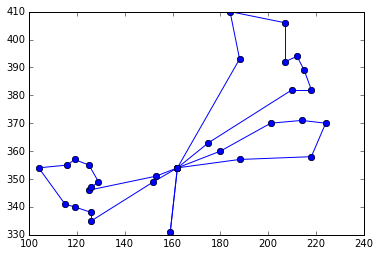

In [10]:
VRP(n, 4, C, Ps, Ds, d, Distance, 60)